<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели.
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import time
import re

import pandas as pd
import numpy as np
import nltk
import spacy
import matplotlib.pyplot as plt

from nltk.corpus import stopwords as nltk_stopwords
from pandarallel import pandarallel
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

In [2]:
nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('toxic_comments.csv', index_col=0)
df.head(2)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Проверим и удалим дубликаты.

In [5]:
df.duplicated().sum()

0

Проверим данные на пропуски.

In [6]:
def show_na(df):
    count = (df.isna() | df.isnull()).sum()
    percent = round(count / df.shape[0], 3) * 100
    res = pd.concat([count, percent], axis=1,  keys=['count', 'percent, %'])\
           .sort_values('count', ascending=False)
    return res

show_na(df)

,count,"percent, %"
text,0,0.0
toxic,0,0.0


Посмотрим на сбалансированность классов в таргете.

In [7]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

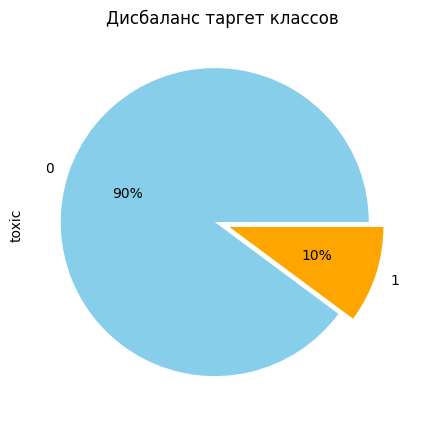

In [8]:
plt.figure(figsize=(5, 5))
df['toxic'].value_counts().plot(
    kind='pie',
    autopct='%1.0f%%',
    colors=['skyblue', 'orange'],
    explode=(0.05, 0.05))
plt.title('Дисбаланс таргет классов')
plt.show()

In [9]:
df.sample(5)

,text,toxic
9361,"Yes, it is a crime. It means you are a racist.",1
58817,"""\n\nBy the way, your 'reference' is about Ale...",0
64681,"""\n Seems like a good solurion until more on t...",0
115400,"""\n\nAfghan Districts\nIs there a local name f...",0
58651,First of I presume you mean COUNTRY not County...,0


Очистим данные от ненужных символов и приведем к нижнему регистру.

In [11]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [12]:
def clear_text(row, re=re):
    row['text'] = ' '.join(re.sub(r'[^a-zA-Z ]', ' ', row['text']).lower().split())
    return row

In [13]:
%%time
df = df.parallel_apply(clear_text, axis=1)

CPU times: total: 484 ms
Wall time: 3.01 s


In [14]:
df.head(2)

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0


Проведем лемматизацию.

In [15]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemma(row, nlp=nlp):
    doc = nlp(row['text'])
    row['text'] = ' '.join([token.lemma_ for token in doc])
    return row

In [16]:
%%time
df = df.parallel_apply(lemma, axis=1)

CPU times: total: 5.69 s
Wall time: 2min 42s


In [17]:
df.sample(4)

,text,toxic
73578,well your comment certainly sound authoritativ...,0
37815,o fenian an anti english racist now there s a ...,1
46007,nothing just a head up people be go through he...,0
19503,good stuff what I be try to say be that the vi...,0


In [18]:
X = df.drop(['toxic'], axis=1)
y = df['toxic']

Разделим данные на обучающую/тестовую выборку размером 80/20.

In [19]:
X, X_test, y, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=33)

In [20]:
X = X['text'].values
X_test = X_test['text'].values

In [21]:
tfid = TfidfVectorizer(stop_words=stopwords)
X_tfid = tfid.fit_transform(X)
X_test_tfid = tfid.transform(X_test)

## Обучение

Протестируем модели на кросс валидации.

In [22]:
def model_info(model, X_train, y_train):
    start = time.time()
    scores = cross_val_score(model, X_train, y_train, cv=3, n_jobs=-1, scoring='f1')
    testing_time = round(time.time() - start, 2)
    return testing_time, scores.mean()

In [23]:
log_model = LogisticRegression(random_state=33, max_iter=1000)
lgbm_model = LGBMClassifier(random_state=33)

In [24]:
%%time
results = [model_info(log_model, X_tfid, y),
           model_info(lgbm_model, X_tfid, y)]

CPU times: total: 141 ms
Wall time: 32.4 s


In [25]:
columns = ['testing time', 'f1 score']
index = ['Log Regression',
         'LGBMClassifier']
pd.DataFrame(results, columns=columns, index=index).sort_values(by='f1 score', ascending=False)

,testing time,f1 score
LGBMClassifier,28.41,0.747426
Log Regression,3.99,0.711327


Подберем гиперпараметры для улучшения показателей модели.

In [26]:
def model_testing(model, params, X_train, y_train):
    start = time.time()
    pipeline = Pipeline([
        ('vect', CountVectorizer(min_df=40, ngram_range=(1, 4), stop_words=stopwords)),
        ('tfidf', TfidfTransformer()),
        ('model', model)])

    grid = GridSearchCV(pipeline, cv=3, n_jobs=4, param_grid=params, scoring='f1')
    grid.fit(X_train, y_train)
    testing_time = time.time() - start
    return grid.best_estimator_, (testing_time, grid.best_score_)

In [27]:
log_param={
    'model__C': [0.5, 1, 5],
    'model__class_weight': ['balanced']}

lgbm_param = {
    'model__learning_rate': [0.05, 0.1],
    'model__num_leaves': [20, 40]}

test_results = []

In [28]:
%%time

log_model, result = model_testing(log_model, log_param, X, y)
test_results.append(result)

lgbm_model, result = model_testing(lgbm_model, lgbm_param, X, y)
test_results.append(result)

pd.DataFrame(test_results, columns=columns, index=index).sort_values(by='f1 score', ascending=False)

CPU times: total: 7min
Wall time: 5min 39s


,testing time,f1 score
LGBMClassifier,262.051944,0.755915
Log Regression,76.991476,0.717539


Лучший показатель у модели LGBMClassifier, выберем ее для финального теста.

## Тестирование лучшей модели

Проверим итоговую модель на тестовых данных.

In [29]:
lgbm_model.fit(X, y)
y_predict = lgbm_model.predict(X_test)
print('f1 метрика на тестовых данных:', f1_score(y_predict, y_test))

f1 метрика на тестовых данных: 0.7638938053097344


Получили довольно не плохой показатель на тестовых данных.

## Выводы

Получили неплохие результаты на кросс-валидации, потом улучшили результат после подбора гиперпараметров и превысили нижний порог метрики f1 в 0,75. На тестовой выборке получили результат еще лучше. Результат можно улучшить, если попробовать подобрать еще больше гиперпараметров для моделей.